<a href="https://colab.research.google.com/github/OlgaNezh/Neural_Networks/blob/main/HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Практическое задание


1. Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность. Приложите анализ



In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import datetime

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/airline-passengers.csv')
df.index = df.Month
df.reset_index(drop=True, inplace=True)


In [5]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


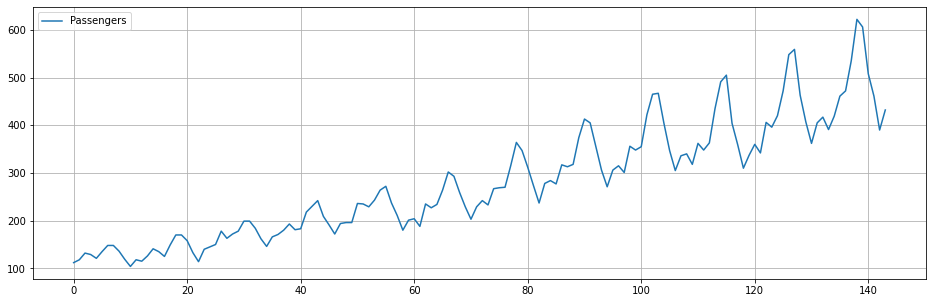

In [6]:
df.plot( figsize = (16,5))
plt.grid('On')
plt.show()

In [7]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [8]:
df_train = df.iloc[:100, :]
df_train.sort_values(by="Month", ascending=True).head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [9]:
df_train['Month'] = pd.to_datetime(df_train.Month)

df_train.Month = df_train.Month.dt.month

In [10]:
df_train.head()

,Month,Passengers
0,1,112
1,2,118
2,3,132
3,4,129
4,5,121


In [11]:
X_train, y_train = df_train, df_train.Passengers

In [12]:
xLEN = 4
batch_size = 5
epochs = 10

train_data = keras.preprocessing.timeseries_dataset_from_array(
    X_train.iloc[:-xLEN,:],
    y_train[xLEN:],
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size
)

In [13]:
for batch in train_data.take(2):
    inputs, targets = batch

In [14]:
targets[0]

<tf.Tensor: shape=(), dtype=int64, numpy=119>

In [15]:
inputs[1,:,:]

<tf.Tensor: shape=(4, 2), dtype=int64, numpy=
array([[  7, 148],
       [  8, 148],
       [  9, 136],
       [ 10, 119]])>

### Тестовая выборка

In [16]:
df_test = df_train = df.iloc[100:, :]
df_test.head()

,Month,Passengers
100,1957-05,355
101,1957-06,422
102,1957-07,465
103,1957-08,467
104,1957-09,404


In [17]:
df_test['Month'] = pd.to_datetime(df_test.Month)

df_test.Month = df_test.Month.dt.month

In [18]:
X_test, y_test = df_test, df_test.Passengers

In [19]:
X_test.head()

,Month,Passengers
100,5,355
101,6,422
102,7,465
103,8,467
104,9,404


In [20]:
data = X_train.copy() # берем все что есть

In [21]:
data.shape[1]

2

In [22]:
data.head()

,Month,Passengers
0,1,112
1,2,118
2,3,132
3,4,129
4,5,121


**Стандартизация**

In [23]:
val_split = 20
scaler = StandardScaler()
data_v = scaler.fit(data[:val_split])
 
data_f = pd.DataFrame(scaler.transform(data))


In [24]:
# список признаков, по которым будем учить
channelIndexes = [0, 1]

# длина теста
valLen = 20

# отступ тестов от тренировок
bias = 3

# вычисляем точку разделения ряда на тесты и тренировку
train_split = data_f.shape[0] - valLen - bias
train_split
# # делим
train_data = data_f.iloc[0 : train_split ,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]

In [25]:
train_data.head(7)

,0,1
0,-1.470906,-1.181840
1,-1.157947,-0.836777
2,-0.844989,-0.031631
3,-0.532030,-0.204162
4,-0.219071,-0.664246
5,0.093888,0.140901
6,0.406846,0.888537


In [26]:
val_data.head(3)

,0,1
80,1.032764,10.320251
81,1.345723,8.134854
82,1.658681,6.006967


Формируем параметры для генерации выборки



In [27]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLEN
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
# batch_size = 5
epochs = 10


In [28]:
Chanel_numb = len(channelIndexes)

start = xLEN + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLEN+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLEN-1:,1].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLEN / step)


x_end = len(val_data) - xLEN - future 

label_start = len(train_data)+bias+xLEN + future +1

xVal_df = val_data.iloc[:-future-xLEN+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLEN-1:,1].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [29]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)


(73, 2)
(73,)
(16, 2)
(16,)


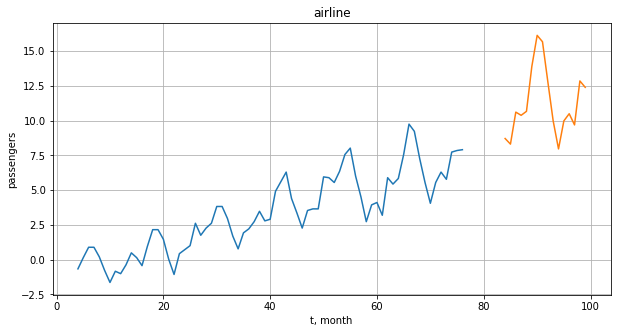

In [30]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLEN:yTrain.shape[0]+xLEN],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+bias+future+2*xLEN-1:],yVal[:])
plt.grid('on')
plt.xlabel('t, month')
plt.ylabel('passengers')
plt.title('airline')
plt.show()

In [31]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size,
)


In [32]:
for batch in dataset_val.take(2):
    inputs, targets = batch

In [33]:
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (5, 4, 2)
Target shape: (5,)


In [34]:
inputs[1,:,:]

<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[-0.84498868, 10.60780356],
       [-0.53202991, 10.37776174],
       [-0.21907114, 10.66531401],
       [ 0.09388763, 13.88589953]])>

In [35]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=13.885899534145489>

In [36]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

сеть: LSTM слои+Conv1D +Dense слой

In [37]:
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True"))
model.add(Conv1D(64, 3, activation="linear"))
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 64)             17152     
                                                                 
 lstm_1 (LSTM)               (None, 4, 64)             33024     
                                                                 
 conv1d (Conv1D)             (None, 2, 64)             12352     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 62,919
Trainable params: 62,919
Non-traina

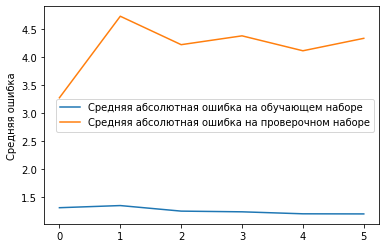

In [38]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback], verbose=0)


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [39]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

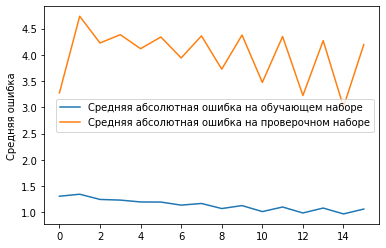

In [40]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback], verbose=0)

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Проверяем результаты:

строим предсказание

рисуем прогноз для тестовой части

рисуем прогноз по тренировочной части

In [42]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

In [43]:
yVal.shape, predVal.shape

((16,), (13,))

Валидация:



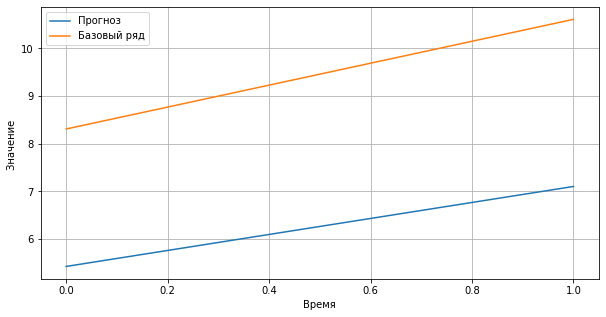

In [44]:
start = 1
step = 2
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()


Тренировочные даннные:


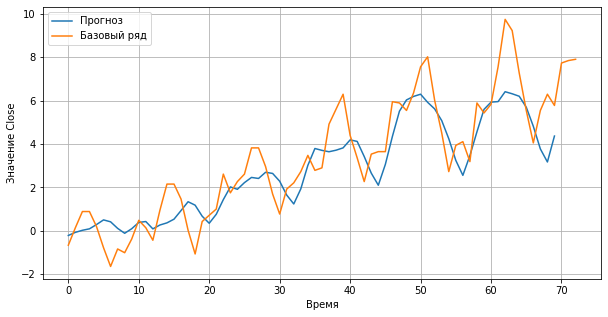

In [45]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()


Проверяем качество модели:

* оценим по лаговой корреляции рядов a, b;
* если наибольшая корреляция с лагом 0, то отлично;
* есди максимум корреляциии на лаге , равном глубине прогноза, то тривиальное предсказание (завтра, как сегодня).



In [46]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

In [47]:
start = 1
step = 3

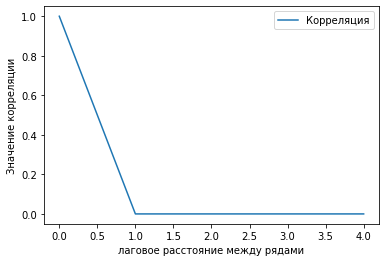

In [48]:
corr = []
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()


In [49]:
corr

[0.9999976632506187, 0, 0, 0, 0]


2. Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения

In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku 
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers


In [52]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(
                num_words=10000,
                filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'",
                lower=True, split=' ')
data = open('/content/drive/MyDrive/Colab Notebooks/alice_in_wonderland.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

In [53]:
corpus[80:100]

['hung upon pegs. she took down a jar from one of the shelves as',
 'she passed; it was labelled ‘orange marmalade’, but to her great',
 'disappointment it was empty: she did not like to drop the jar for fear',
 'of killing somebody, so managed to put it into one of the cupboards as',
 'she fell past it.',
 '',
 '‘well!’ thought alice to herself, ‘after such a fall as this, i shall',
 'think nothing of tumbling down stairs! how brave they’ll all think me at',
 'home! why, i wouldn’t say anything about it, even if i fell off the top',
 'of the house!’ (which was very likely true.)',
 '',
 'down, down, down. would the fall never come to an end! ‘i wonder how',
 'many miles i’ve fallen by this time?’ she said aloud. ‘i must be getting',
 'somewhere near the centre of the earth. let me see: that would be four',
 'thousand miles down, i think--’ (for, you see, alice had learnt several',
 'things of this sort in her lessons in the schoolroom, and though this',
 'was not a very good opportuni

Исполним токенизацию и кодирование

In [54]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [55]:
token_list

[3397, 4, 367, 1307, 3398, 4, 278, 38, 497, 622]

In [56]:
tokenizer.index_word[30]

'but'

In [57]:
tokenizer.word_index['love']

1065

In [58]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         22, 444,  31,  24,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22,
        444,  31,  24,   1, 150],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 444,
         31,  24,   1, 150,   6],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 444,  31,
         24,   1, 150,   6, 707]], dtype=int32)

In [59]:
label.shape

(28231, 3399)

Создаем сеть

In [61]:
callback = EarlyStopping(monitor='val_loss', patience=10) # создаем обратный вызов - calback - тут "Ранний останов"


In [62]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(128))
model.add(Dropout( 0.2))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 256)           870144    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1699)              219171    
                                                                 
 dense_3 (Dense)             (None, 3399)              5778300   
                                                                 
Total params: 7,064,735
Trainable params: 7,064,735
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
history = model.fit(predictors,
                    label,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[callback],
                    verbose=0)


Тест


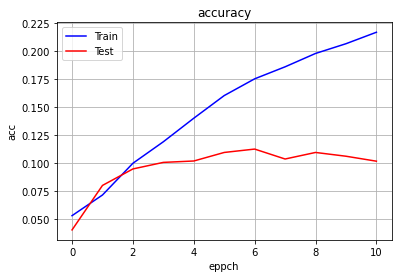

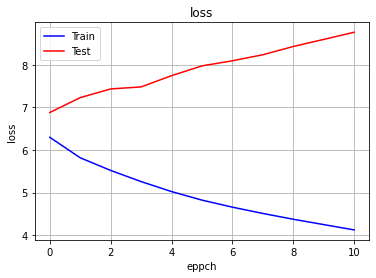

In [64]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')
plt.xlabel('eppch')
plt.ylabel('acc')
plt.grid()
plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.xlabel('eppch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

Строим тест генератора

In [75]:
# начальная строка
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "machine learning is true"
next_words = 10
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
  predicted = model.predict(token_list, verbose=0)
  predict_ = np.argmax(predicted)
  output_word = ""
  print(predict_)
  # добавим новое слово в последовательность
  for word, index in tokenizer.word_index.items():
    if index == predict_:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[360, 69, 11, 1311, 80, 107, 841]
2
[360, 69, 11, 1311, 80, 107, 841, 2]
9
[360, 69, 11, 1311, 80, 107, 841, 2, 9]
12
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 12]
10
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 12, 10]
5
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 12, 10, 5]
32
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 12, 10, 5, 32]
125
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 12, 10, 5, 32, 125]
3
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 12, 10, 5, 32, 125, 3]
1
[360, 69, 11, 1311, 80, 107, 841, 2, 9, 12, 10, 5, 32, 125, 3, 1]
67
Help me Obi Wan Kenobi, you're my only hope ’ said alice in a little tone and the queen


Посмотрим на предсказание через вероятные ответы


In [76]:
y_p=model.predict(token_list)


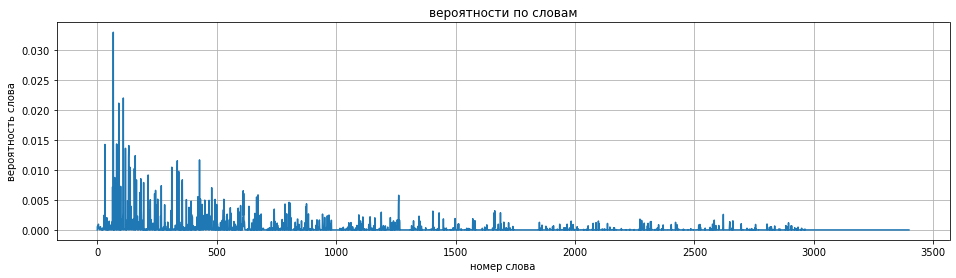

In [77]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [78]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

array([], dtype=int64)

In [79]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

In [86]:
seed_text = "She is my girl, I see in"
next_words = 15
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p=model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[7, 31, 80, 840, 15, 65, 10]
[7, 31, 80, 840, 15, 65, 10, 5]
[7, 31, 80, 840, 15, 65, 10, 5, 127]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32, 27]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32, 27, 162]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32, 27, 162, 2]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32, 27, 162, 2, 9]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32, 27, 162, 2, 9, 1]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32, 27, 162, 2, 9, 1, 137]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32, 27, 162, 2, 9, 1, 137, 79]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32, 27, 162, 2, 9, 1, 137, 79, 15]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32, 27, 162, 2, 9, 1, 137, 79, 15, 115]
[7, 31, 80, 840, 15, 65, 10, 5, 127, 32, 32, 27, 162, 2, 9, 1, 137, 79, 15, 115, 25]
She is my girl, I see in a great little little or day ’ said the cat ‘and i can be a


Построим более сложную модель.

In [80]:
model2 = Sequential()
model2.add(Embedding(total_words, 256, input_length=max_sequence_len-1))

model2.add(LSTM(128, return_sequences="True"))
model2.add(LSTM(64, return_sequences="True"))
model2.add(Conv1D(32, 3, activation="linear"))
model2.add(Conv1D(16, 1, activation="linear"))
model2.add(Dropout( 0.2))
model2.add(Flatten())
model2.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(total_words, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())

# model2.add(Conv1D(64, 3, activation="linear"))
#model.add(Conv1D(64, 1, activation="linear"))
# model2.add(Flatten())                        

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 17, 256)           870144    
                                                                 
 lstm_3 (LSTM)               (None, 17, 128)           197120    
                                                                 
 lstm_4 (LSTM)               (None, 17, 64)            49408     
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            6176      
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 16)            528       
                                                                 
 dropout_1 (Dropout)         (None, 15, 16)            0         
                                                                 
 flatten_1 (Flatten)         (None, 240)              

In [81]:
history = model2.fit(predictors,
                    label,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[callback],
                    verbose=0)

Тест

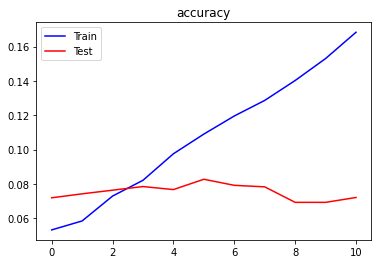

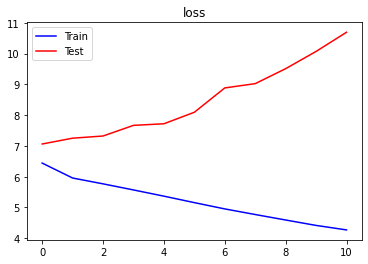

In [82]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()


Строим тест генератора

In [97]:
# начальная строка
seed_text = "She is my girl, I see in"
#seed_text = "machine learning is true"
next_words = 15
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding = 'pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
  predicted = model2.predict(token_list, verbose=0)
  predict_ = np.argmax(predicted)
  output_word = ""
  print(predict_)
  # добавим новое слово в последовательность
  for word, index in tokenizer.word_index.items():
    if index == predict_:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[7, 31, 80, 840, 15, 65, 10]
2
[7, 31, 80, 840, 15, 65, 10, 2]
9
[7, 31, 80, 840, 15, 65, 10, 2, 9]
12
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12]
229
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229]
430
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229, 430]
5
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229, 430, 5]
29
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229, 430, 5, 29]
1716
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229, 430, 5, 29, 1716]
2
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229, 430, 5, 29, 1716, 2]
1
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229, 430, 5, 29, 1716, 2, 1]
543
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229, 430, 5, 29, 1716, 2, 1, 543]
9
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229, 430, 5, 29, 1716, 2, 1, 543, 9]
4
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229, 430, 5, 29, 1716, 2, 1, 543, 9, 4]
72
[7, 31, 80, 840, 15, 65, 10, 2, 9, 12, 229, 430, 5, 29, 1716, 2, 1, 543, 9, 4, 72]
103
She is my girl, I see in ’ said alice ‘i’m thinking a very proud ’ the ‘off said to its head


In [98]:
y_p=model2.predict(token_list)

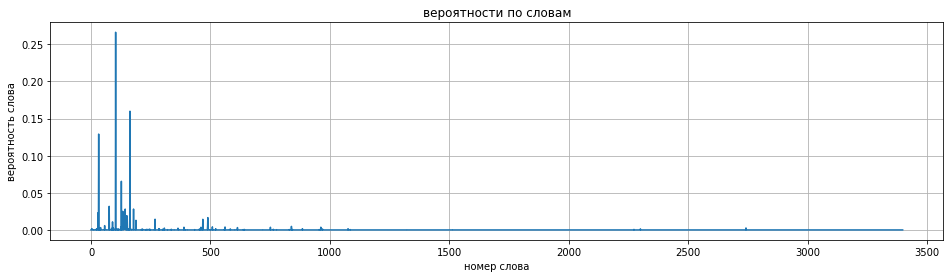

In [99]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [100]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

array([ 32, 103, 127, 163])

In [101]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])


little  :  0.1290764
head  :  0.2662356
great  :  0.06549851
eyes  :  0.1598786
